# CarRacing-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/record".format(args.env_name)
model_path_name = "results/{}/tf_vae".format(args.env_name)

In [4]:
filelist = os.listdir(DATA_DIR)

In [5]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [6]:
obs.shape

(1000, 64, 64, 3)

In [22]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [23]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

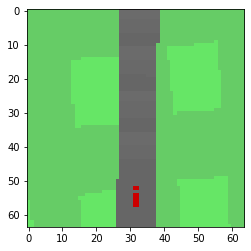

In [24]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [25]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.4229 -0.5835  1.499  -0.9198 -1.2617  0.0103  0.2604  0.3346 -0.9192  1.6444  0.5335 -0.8728
  0.1969 -0.4996 -0.9971 -0.3211 -0.9808  0.4697 -0.0946  0.3367 -0.9958  0.9951 -1.2073 -0.2199
  0.1866  1.3587 -0.3065  0.5921 -0.6354 -1.5151 -0.4099  1.6041], shape=(32,), dtype=float32)


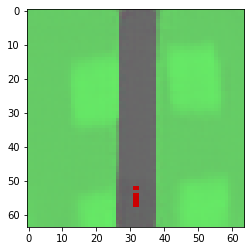

In [26]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

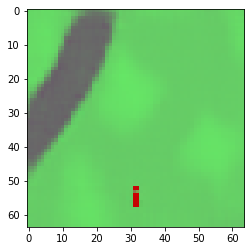

In [12]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Driving in true environment
visualize what the agent sees when driving in the true environment

In [13]:
def sim(c, env, vae, is_true_env=False, z_size=64, max_ep_len=1000):
    o = env.reset()
    r_list = []
    total_r_list = []
    true_frames = []
    if is_true_env:
        o, frame = o
        true_frames.append(tf.squeeze(frame))
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    else:
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    
    for _ in range(max_ep_len): # episode length is a thousand
        a = c.get_action(o)
        o, r, d, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, frame = o
            true_frames.append(tf.squeeze(frame))
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        else:
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
        
        if d:
            break
    return decoded_frames, true_frames, r_list, total_r_list

In [14]:
c = make_controller(args)
c.load_model('results/{}/log/{}.cma.16.64.json'.format(args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

loading file results/CarRacing-v0/log/CarRacing-v0.cma.16.64.json
making real CarRacing environment
Track generation: 1241..1555 -> 314-tiles track


<IPython.core.display.Javascript object>


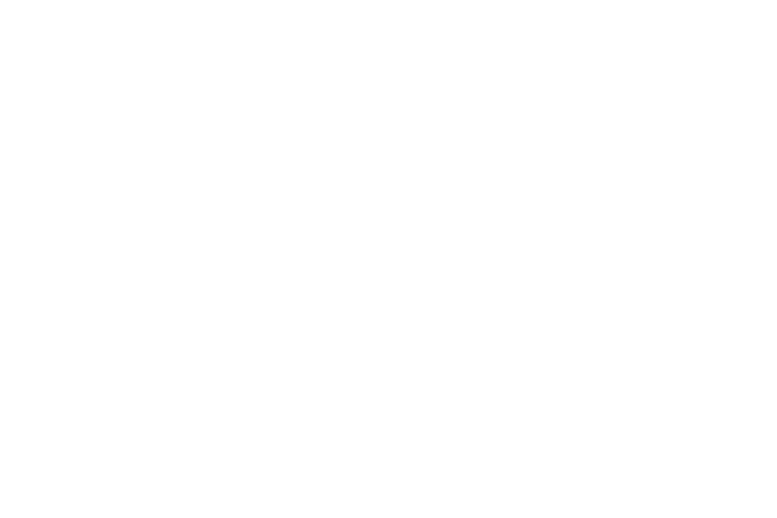

<IPython.core.display.Javascript object>


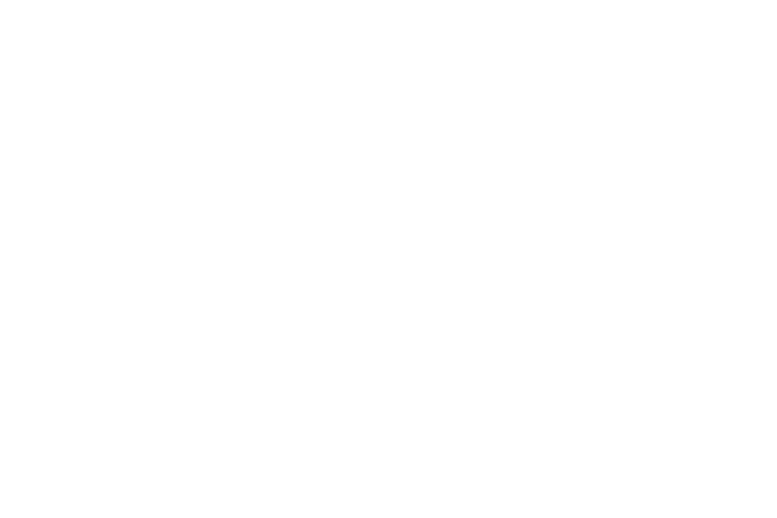

Traceback (most recent call last):
  File "/home/vincent/anaconda3/envs/hy/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/vincent/anaconda3/envs/hy/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [15]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Plot for Controller

In [10]:
ours_vae_filepath = os.path.join('results/{}/log/{}.cma.{}.{}.eval_hist.json'.format(args.env_name, args.env_name,args.controller_num_episode,args.controller_num_worker))
#ours_gan_filepath = os.path.join('results/{}/log/{}.cma.{}.{}.eval_hist.json'.format(args.env_name, args.env_name,args.controller_num_episode,args.controller_num_worker))
old_vae_filepath = os.path.join('results_copy/{}/log/{}.cma.16.64.eval_hist.json'.format(args.env_name, args.env_name))
og_filepath = os.path.join('results/{}/origin'.format(args.env_name), 'carracing.cma.16.64.hist_best.json')

with open(old_vae_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)
with open(ours_vae_filepath,'r') as f:
    our_vae_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)
our_vae_data = np.array(our_vae_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
our_vae_comparison_max = our_vae_data[-1, 0]
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

8


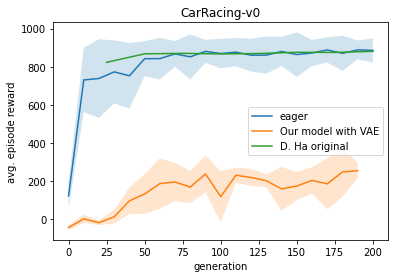

In [14]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

our_vae_x = our_vae_data[:, 0]
our_vae_ret = our_vae_data[:, 1]
our_vae_std = our_vae_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

fig = plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(our_vae_x,our_vae_ret)
plt.fill_between(our_vae_x, our_vae_ret-our_vae_std, our_vae_ret+our_vae_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'Our model with VAE','D. Ha original'])

In [15]:
fig.savefig('Reward_results.png', dpi=fig.dpi)